# Visualizing Barren Plateaus

[References](https://github.com/Gopal-Dahale/ILearnQuantum/blob/main/layerwise_learning_with_qiskit_and_pytorch/barren_plateaus_visualization.ipynb)

In [1]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit import QuantumCircuit
import os
from qiskit.primitives import Estimator

seed = 42
np.random.seed(seed)

In [2]:
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
import torch
from torch import nn
import pandas as pd

from sklearn.decomposition import PCA

from Components.train import train, train_batch
from Components.data import cancer_data
from Components.circuits import *
from Components.gradients import *
from Components.log_ops import *
from Components.utils import *

/var/folders/yl/5cj99xpd0cg5xn4st7_dyz6m0000gn/T/ipykernel_40530/879163501.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
surface0 = pd.read_csv('Logs-Cancer-v4/m0/LossFunctionSurface.csv', index_col=0)
surface1 = pd.read_csv('Logs-Cancer-v4/m1/LossFunctionSurface.csv', index_col=0)
surface2 = pd.read_csv('Logs-Cancer-v4/m2/LossFunctionSurface.csv', index_col=0)
surface3 = pd.read_csv('Logs-Cancer-v4/m3/LossFunctionSurface.csv', index_col=0)

In [23]:
def plot_surface(data:pd.DataFrame, title = None, dpi = 80):
    '''
    use %matplotlib widget for interative plot!
    '''

    parameters = data.iloc[:,:-1]
    zValue = parameters.iloc[:,-1]

    pca = PCA(n_components=2)
    pca.fit(parameters)
    principalData = pca.transform(parameters)
    print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')
    principalDataDF = pd.DataFrame(principalData, columns=['x', 'y'])
    principalDataDF['z'] = zValue

    from mpl_toolkits.mplot3d import Axes3D
    xs = principalDataDF['x']
    ys = principalDataDF['y']
    zs = principalDataDF['z']

    fig = plt.figure(figsize=(10, 10), dpi=dpi)
    ax = fig.add_subplot(111, projection='3d')

    ax.set_xlabel('Params PC1')
    ax.set_ylabel('Params PC2')
    ax.set_zlabel('Pauli-Z Expectation')

    if title:
        ax.set_title(title)

    plot = ax.plot_trisurf(xs,
                       ys,
                       zs,
                       cmap=plt.get_cmap('rainbow'),
                       linewidth=1,
                       antialiased=False,
                       alpha=0.6)

    plt.show()
    

Explained Variance Ratio: [0.02637827 0.02590188]


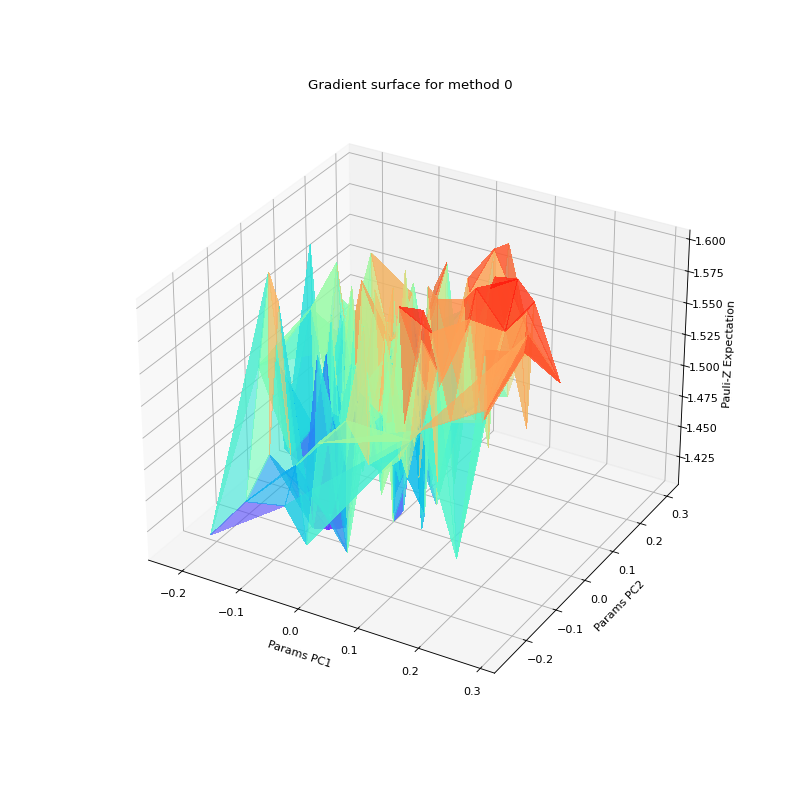

In [24]:
%matplotlib widget
plot_surface(surface0, 'Gradient surface for method 0')

Explained Variance Ratio: [0.07179541 0.06692732]


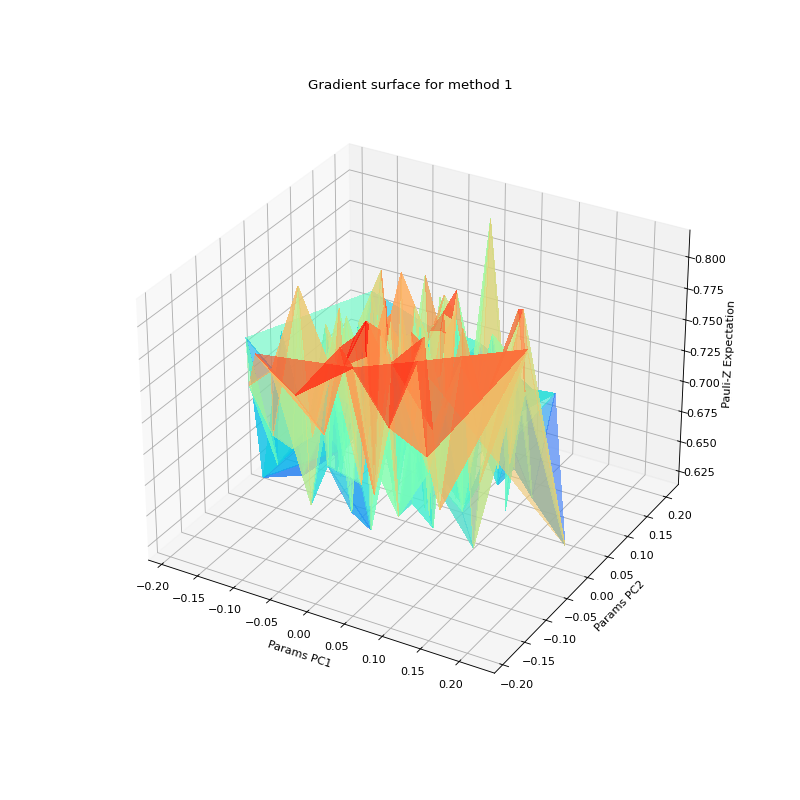

In [16]:
%matplotlib widget
plot_surface(surface1, 'Gradient surface for method 1')

Explained Variance Ratio: [0.02892266 0.02581112]


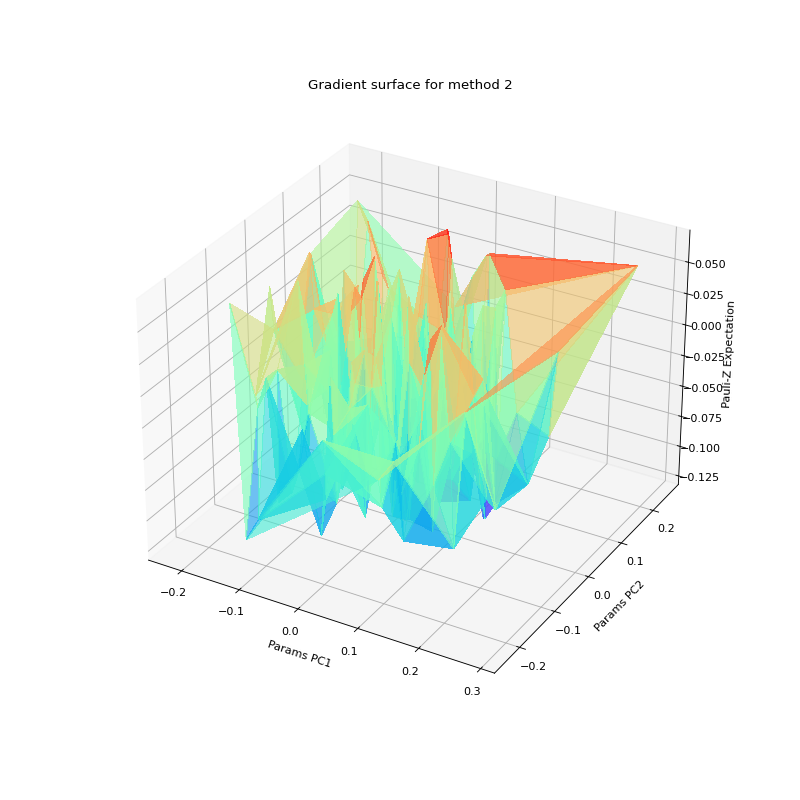

In [17]:
%matplotlib widget
plot_surface(surface2, 'Gradient surface for method 2')

Explained Variance Ratio: [0.02604273 0.02515472]


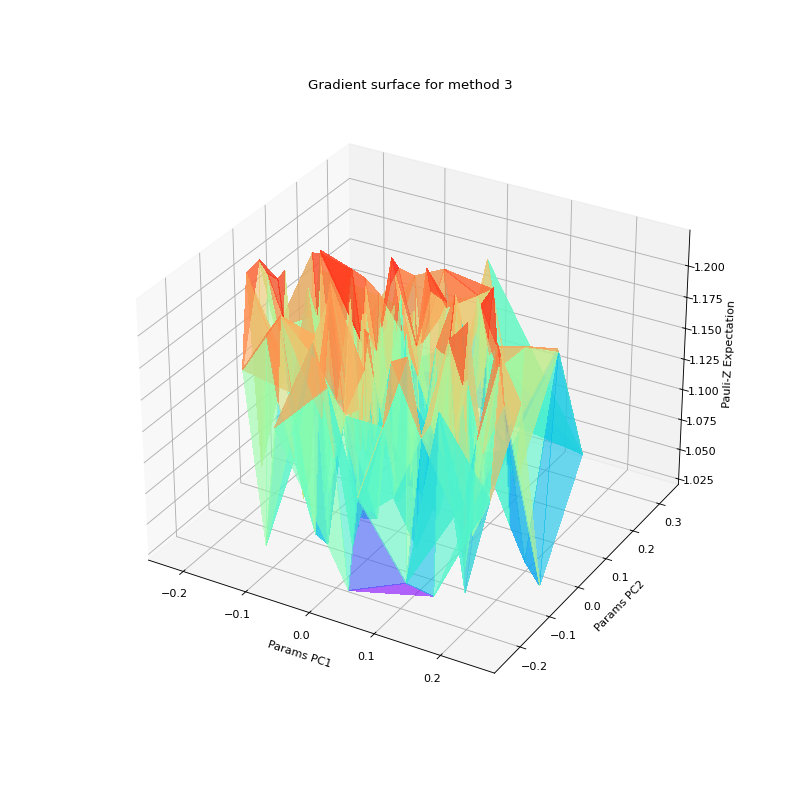

In [18]:
%matplotlib widget
plot_surface(surface3, 'Gradient surface for method 3')